# Correlation Matrix & CSVs Notebook

Author: Izzy Pfander

This notebook creates correlation matrices and CSVs listsing correlation and p-value. We divide the data into categorical and continuous groups to run Pearsons (continuous) and Cramer's V (categorical) correlation. 

Because of the size of the dataset, correlation is run looking for 'fields of interest'.

**Part One**:
* import data and identify columns
* separate data into continuous and categorical 

**Part Two**
* create correlation matrices
* if too large, export matrices as csvs

**Part Three**
* one hot encode categorical data
* create csvs with correlation and p-value

## Part One

In [1]:
import numpy as np 
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn import preprocessing
import scipy.stats

In [2]:
# import data
with open('data_files.json', 'rt') as data_f:
    file_paths = json.load(data_f)

##### Define target file from avalable.

Options:
>'all_data', 'production', 'geohazard', 'incidents', 'metocean', 'structures', 'well_stats', 'platforms'

Add more in `data_files.json`

In [1]:
key = 'platforms'
target_file = file_paths[key]
target_df = pd.read_csv(target_file, low_memory=False)
target_df = target_df.replace(-999999, np.nan)
target_df = target_df.replace('-999999', np.nan)

Utility functions from previous work:

In [ ]:
def identify_csv_cols(df, target=None, ignore=None):
    """
    Read CSV and return all possible continuous/categorical columns
    Args:
        df: pandas df from .csv file
        target: dependent feature to remove from cont/cat columns

    Returns: tuple(list, list) of (continous, categorical) column names

    """

    # Remove bad spaces
    df.columns = df.columns.str.replace(r"\xa0", " ")
    columns = df.columns
    if ignore:
        columns = [x for x in df.columns if x not in ignore]

    continuous = []
    categorical = []

    for col in columns:
        # Float values are continous, int values are sometimes continuous
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            continuous.append(col)

        # Treat strings categorical variables
        elif df[col].dtype == 'object':
            categorical.append(col)

        else:
            print("Not sure what to do with {}".format(col))

    if target:
        if target in continuous:
            continuous.remove(target)
        if target in categorical:
            categorical.remove(target)

    return continuous, categorical

### Grab Continuous and Categorical columns:

In [2]:
""" Create a dictionary to track categorical vs continuous columns
Doing this as a dict becase the values can be flags and we can go edit them easily to change type
as types were inferred with `identify_csv_cols()`
"""
cont, cat = identify_csv_cols(target_df)
cont_dict = {feature:0 for feature in cont}
cat_dict = {feature:1 for feature in cat}
col_types = {**cont_dict, **cat_dict}

with open('all_columns.json', 'w') as col_type_f:
    json.dump(col_types, col_type_f)


""" Now that file is created, we don't have to remake it every time. Just load into a dict for 
any of the category files as the dict was created from the 'all_data' file.
Continuous == 0
Categorical == 1
Dont Include == 2
"""
# Load the dictionary we created above,
with open('all_columns.json', 'rt') as col_type_f:
    col_types = json.load(col_type_f)

### Continuous data

In [3]:
cont = [col for col in target_df.columns if col_types[col] == 0]
cont_struct = target_df[cont]
cont_struct

### Categorical data

In [ ]:
cat = [col for col in target_df.columns if col_types[col] == 1]
cat_struct = target_df[cat]
cat_struct

## Part Two

### Correlation Matrix (Continuous Data) - Pearson's

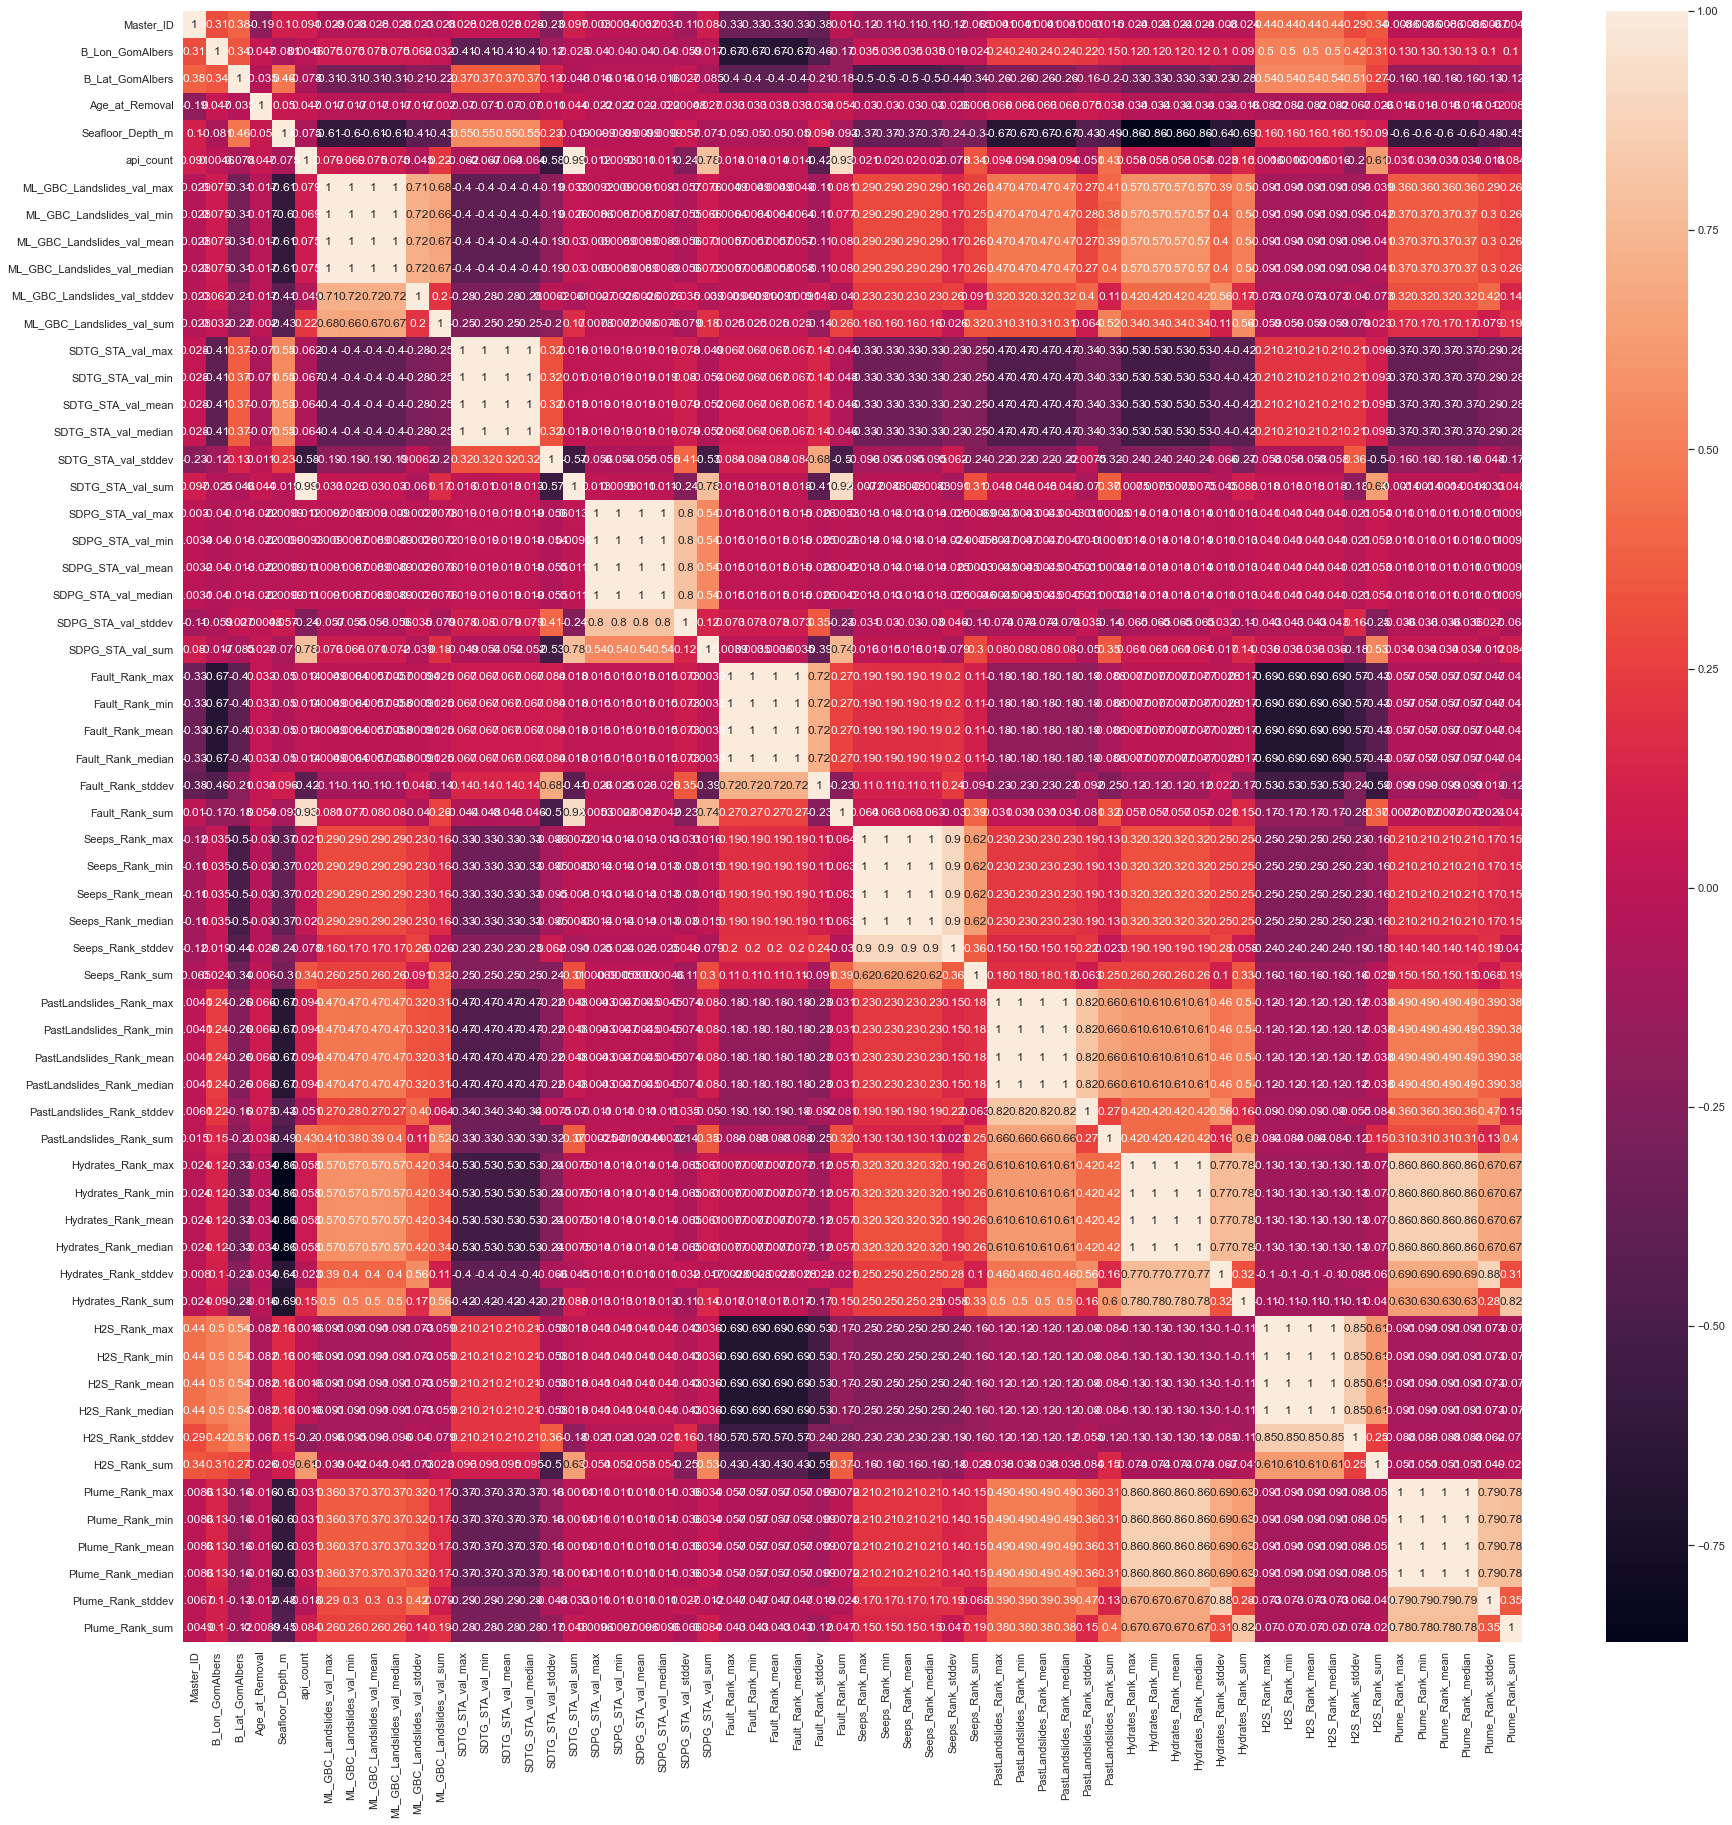

In [36]:
# create correlation matrix
corrMatrix = cont_struct.corr(method='pearson', min_periods=10)
sns.set(rc = {'figure.figsize':(30,30)})
sns.heatmap(corrMatrix, annot=True)

plt.savefig(key + '_pearson_correlation_matrix.pdf', bbox_inches='tight')
plt.savefig(key + '_pearson_correlation_matrix.png', bbox_inches='tight')
plt.show()

### Correlation Matrix (Categorical Data) - Cramer's V

cramer's V wiki: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

Based on function under Apache 2.0 license: https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix/notebook

In [37]:
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in cat_struct.columns :
  data_encoded[i]=label.fit_transform(cat_struct[i])

In [38]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  pval = chi2_contingency(crosstab)[1]
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return [(stat/(obs*mini)), pval]

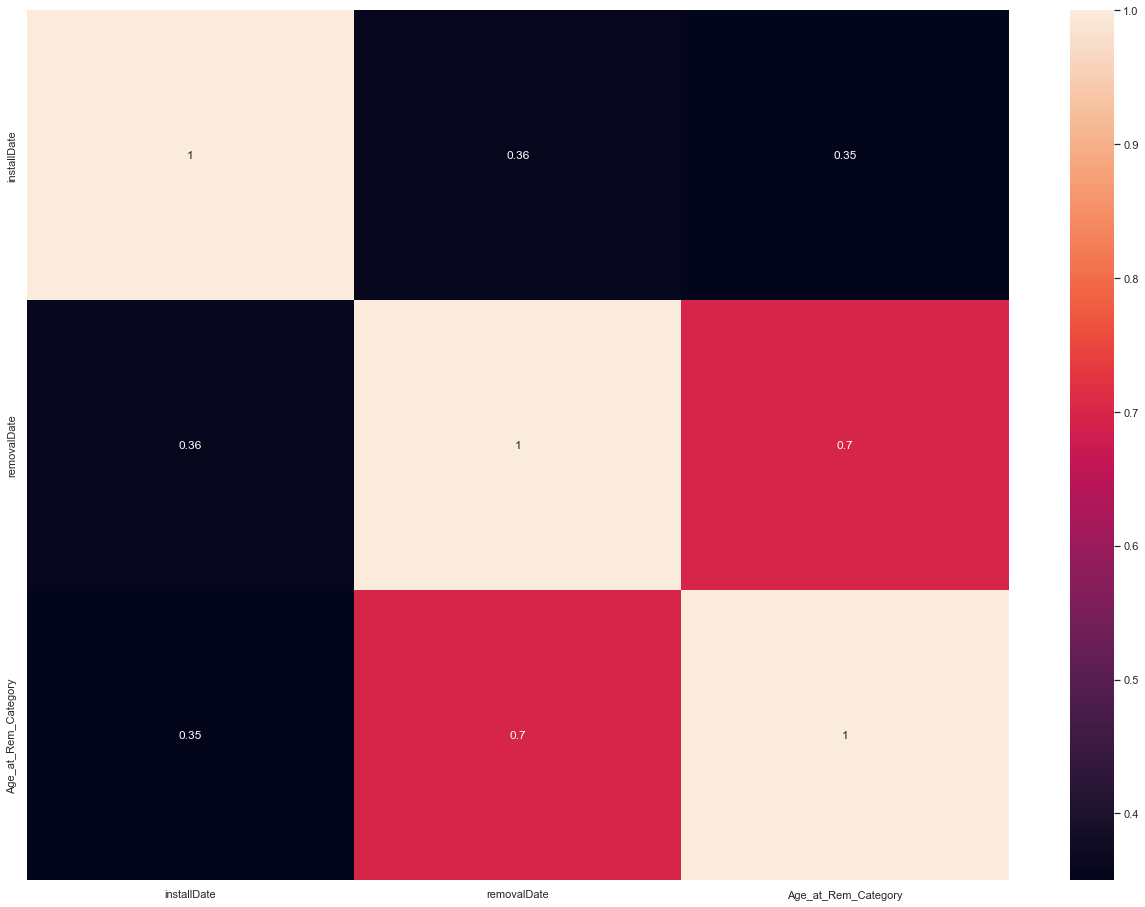

In [40]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2])[0] # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

sns.set(rc = {'figure.figsize':(22,16)})
sns.heatmap(df, annot=True)

plt.savefig(key + '_cramers_v_matrix.png', bbox_inches='tight')
plt.show()

Save outputs to CSV if the image was too packed

In [98]:
df.to_csv(key + '_cramers_v_matrix.csv')
corrMatrix.to_csv(key + '_pearson_correlation_matrix.csv')

## Part Three

### Create csv with p values and Pearson's r

Here I am creating function to return p value for Pearson's

To get correlation between all variables in the updated dataset, rerun part one with the key = 'platforms'

### One-hot encoding

Add any fields you want to cat_cols to be encoded

In [12]:
# creating smaller subset of categorical features for one hot encoding
cat_cols = []
cat_subset = cat_struct[cat_cols]

In [4]:
ohe = preprocessing.OneHotEncoder()

X_object = cat_subset.select_dtypes('object')
ohe.fit(X_object)

codes = ohe.transform(X_object).toarray()
feature_names = ohe.get_feature_names(cat_cols)

cat_ohe = pd.concat([cat_subset.select_dtypes(exclude='object'), 
               pd.DataFrame(codes,columns=feature_names).astype(int)], axis=1)
cat_ohe

### Fields of interest

To filter down results, we are looking for correlation with 'fields of interest'

In [27]:
# Add categorical fields of interest
fields_interest = []
for col in fields_interest:
    cat_ohe.loc[:,col] = cont_struct.loc[:,col]

### P-value csv functions

In [ ]:
# creating df with cols: X, Y, r, p
def create_pearson_corr_df(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalue = []
    pearsonr = []
    x = []
    y = []
    for r in fields_interest:
        for c in df.columns:
            if ((c in x) == False) and (r != c):
                xy_df = pd.DataFrame()
                xy_df[r] = df[r]
                xy_df[c] = df[c]
                xy_df = xy_df.dropna()
                if (len(xy_df[r]) < 2) or (len(xy_df[c]) < 2):
                    pvalue.append(np.nan)
                    pearsonr.append(np.nan)
                else:
                    pvalue.append(round(scipy.stats.pearsonr(xy_df[r], xy_df[c])[1], 4))
                    pearsonr.append(round(scipy.stats.pearsonr(xy_df[r], xy_df[c])[0], 4))
                x.append(r)
                y.append(c)
    returndf = pd.DataFrame()
    returndf['X'] = x
    returndf['Y'] = y
    returndf['Pearson\'s r'] = pearsonr
    returndf['P-value'] = pvalue
    return returndf

corr_df = create_pearson_corr_df(cat_ohe)
corr_df.to_csv(key + '_pearson_correlation_categorical_ohe_all.csv')

C:\Users\pfanderi\.conda\envs\geo_env\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Returning p value for Cramer's V

WARNING: running Cramer's V on categorical fields with continuous fields of interest will result in all fields treated as categorical

In [42]:
# creating df with cols: X, Y, chi2, p
def create_cramers_v_df(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalue = []
    chi2 = []
    x = []
    y = []
    for r in df.columns:
        for c in df.columns:
            if ((c in x) == False) and (r != c):
                xy_df = pd.DataFrame()
                xy_df[r] = df[r]
                xy_df[c] = df[c]
                xy_df = xy_df.dropna()
                if (len(xy_df[r]) < 2) or (len(xy_df[c]) < 2):
                    pvalue.append(np.nan)
                    chi2.append(np.nan)
                else:
                    pvalue.append(cramers_V(xy_df[r],xy_df[c])[1])
                    chi2.append(cramers_V(xy_df[r],xy_df[c])[0])
                x.append(r)
                y.append(c)
    returndf = pd.DataFrame()
    returndf['X'] = x
    returndf['Y'] = y
    returndf['Chi2'] = chi2
    returndf['P-value'] = pvalue
    return returndf

corr_df = create_cramers_v_df(cat_struct)
corr_df.to_csv(key + '_cramers_correlation_pval_original.csv')